In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [2]:
autoencoder = tf.keras.models.load_model('../modelos/autoencoder_model.keras')

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                   "exams_part2.hdf5", "exams_part3.hdf5", "exams_part4.hdf5", "exams_part5.hdf5",
                   "exams_part6.hdf5", "exams_part7.hdf5", "exams_part8.hdf5", "exams_part9.hdf5",
                   "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                   "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 1)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 1)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:20000]

ids_ecgs= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 134657
Número de linhas ecg_doente_linhas: 5609
Tirando Interferência:
Número de linhas ecg_normal_linhas: 130877
Número de linhas ecg_doente_linhas: 5432
Número de ecgs pra clusterizar: 25432


In [4]:
#X
arquivos_hdf5 = ["../Database/filtered_exams_0_1.hdf5",
                 "../Database/filtered_exams_2_3.hdf5",  "../Database/filtered_exams_4_5.hdf5",
                 "../Database/filtered_exams_6_7.hdf5",  "../Database/filtered_exams_8_9.hdf5",
                 "../Database/filtered_exams_10_11.hdf5",  "../Database/filtered_exams_12_13.hdf5",
                 "../Database/filtered_exams_14_15.hdf5", "../Database/filtered_exams_16_17.hdf5"]

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])

Número de ecgs que eram pra ser processados: 25432
Número total de traçados processados: 25432


In [5]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

epsilon = 1e-10

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

# Substituir os valores NaN por epsilon
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

epsilon = 1e-10
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

C:\Users\pedro\AppData\Local\Temp\ipykernel_20932\144704460.py:9: RuntimeWarning: invalid value encountered in divide
  X = X / np.max(np.abs(X), axis=1, keepdims=True)


795/795 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step
(25432, 128, 1)
(25432, 128)


In [6]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=7, min_dist=0.0, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

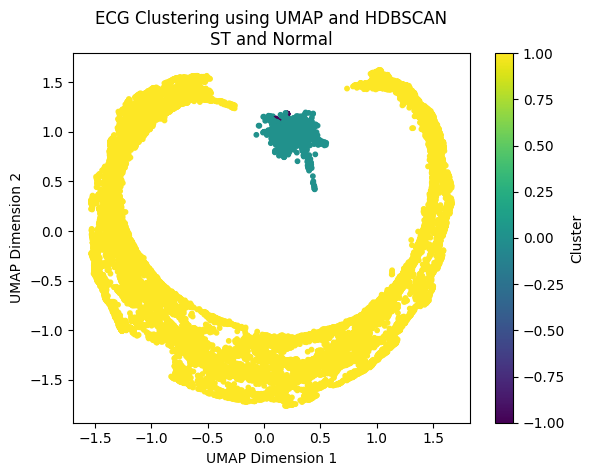

Cluster 0: Pontuação de Estabilidade = 0.3345719770674379
Cluster 1: Pontuação de Estabilidade = 0.2902086305244666


C:\Users\pedro\AppData\Local\Temp\ipykernel_20932\1459738422.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


F1 Score: 0.8125142949274082
   cluster  1dAVb  RBBB  LBBB  SB  ST    AF  normal_ecg
0       -1      0     0     0   0   0    45           0
1        0      0     0     0   0   0  3569         447
2        1      0     0     0   0   0  1818       19553


In [21]:
#CLUSTERIZACAO HDBSCAN


from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=1000, min_samples=70)
labels = dbscan.fit_predict(X_reduced_scaled)

# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=10)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\nST and Normal')
plt.colorbar(label='Cluster')
plt.show()
cluster_stability = dbscan.cluster_persistence_

# Para visualizar:
for i, score in enumerate(cluster_stability):
    print(f"Cluster {i}: Pontuação de Estabilidade = {score}")
# Calcular e imprimir os scores
#silhouette_avg = silhouette_score(X_reduced_scaled, labels)
#print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, labels, average='weighted')
print(f'F1 Score: {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

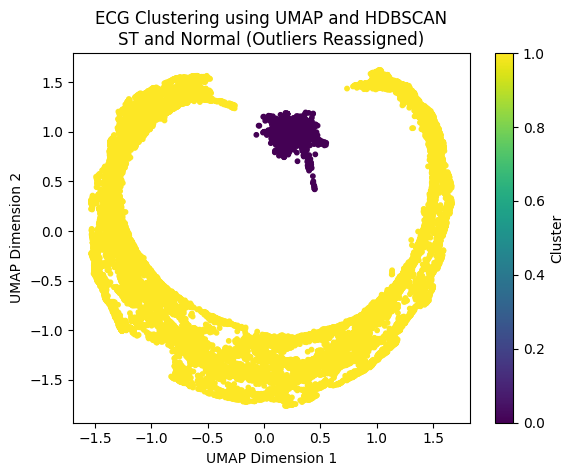

Silhouette Score (Outliers Reassigned): 0.31247881054878235


C:\Users\pedro\AppData\Local\Temp\ipykernel_20932\2368386030.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


F1 Score (Outliers Reassigned): 0.8124241212579193
   cluster  1dAVb  RBBB  LBBB  SB  ST    AF  normal_ecg
0        0      0     0     0   0   0  3614         447
1        1      0     0     0   0   0  1818       19553


In [8]:
# CLUSTERIZACAO HDBSCAN

from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN

# Normalização dos dados
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Configuração e execução do HDBSCAN
dbscan = HDBSCAN(min_cluster_size=2000, min_samples=1, cluster_selection_epsilon = 1000000000000000000000000, alpha=0.000000000000000000000000000000000000000005)
labels = dbscan.fit_predict(X_reduced_scaled)

# Identificar os outliers
outliers_mask = (labels == -1)
outliers = X_reduced_scaled[outliers_mask]

# Identificar os pontos clusterizados (não-outliers)
clustered_points = X_reduced_scaled[~outliers_mask]
cluster_labels = labels[~outliers_mask]

# Encontrar o cluster mais próximo para cada outlier
closest_clusters, _ = pairwise_distances_argmin_min(outliers, clustered_points)

# Atribuir os outliers ao cluster mais próximo
new_labels = labels.copy()
new_labels[outliers_mask] = cluster_labels[closest_clusters]

# Visualização dos Resultados com Outliers Reagrupados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=new_labels, cmap='viridis', s=10)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\nST and Normal (Outliers Reassigned)')
plt.colorbar(label='Cluster')
plt.show()

# Calcular e imprimir os scores com os novos rótulos
silhouette_avg = silhouette_score(X_reduced_scaled, new_labels)
print(f'Silhouette Score (Outliers Reassigned): {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': new_labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, new_labels, average='weighted')
print(f'F1 Score (Outliers Reassigned): {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

Silhouette Score médio: 0.27777475118637085

Silhouette Score médio por cluster:
cluster
-1    0.660971
 0    0.534145
 1    0.228791
Name: silhouette_score, dtype: float32


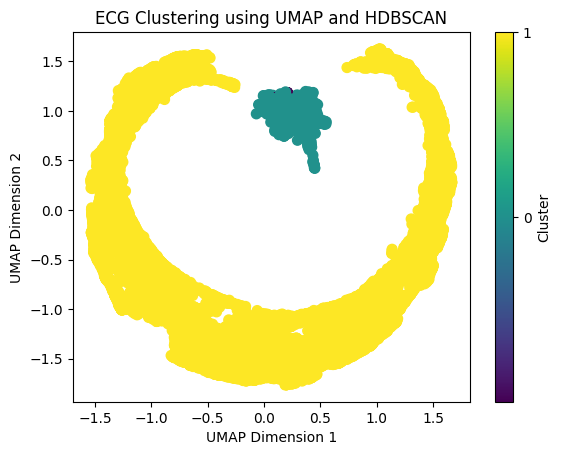

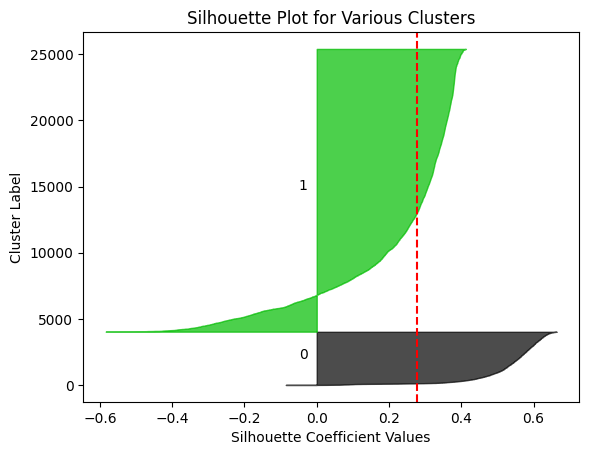

   cluster  1dAVb  RBBB  LBBB  SB  ST    AF  normal_ecg  total  \
0       -1      0     0     0   0   0    45           0     45   
1        0      0     0     0   0   0  3569         447   4016   
2        1      0     0     0   0   0  1818       19553  21371   

   normal_percentage  
0           0.000000  
1          11.130478  
2          91.493145  

Cluster com a menor porcentagem de ECGs normais:
cluster              -1.0
1dAVb                 0.0
RBBB                  0.0
LBBB                  0.0
SB                    0.0
ST                    0.0
AF                   45.0
normal_ecg            0.0
total                45.0
normal_percentage     0.0
Name: 0, dtype: float64


In [9]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score




# Calcular o silhouette score médio
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score médio: {silhouette_avg}')

# Calcular o silhouette score para cada ponto
silhouette_values = silhouette_samples(X_reduced_scaled, labels)

# Número de clusters encontrados
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Criar um DataFrame para os silhouette scores
silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels,
    'silhouette_score': silhouette_values
})

# Calcular o silhouette score médio para cada cluster separado
cluster_silhouette_avg = silhouette_df.groupby('cluster')['silhouette_score'].mean()
print("\nSilhouette Score médio por cluster:")
print(cluster_silhouette_avg)

# Visualização dos clusters
scatter = plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster', ticks=range(n_clusters))
plt.show()

# Visualização das pontuações de silhueta
y_lower = 10

for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.title('Silhouette Plot for Various Clusters')
plt.axvline(x=silhouette_avg, color='red', linestyle='--')
plt.show()

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Calcular a porcentagem de ECGs normais em cada cluster
cluster_summary['total'] = cluster_summary[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF', 'normal_ecg']].sum(axis=1)
cluster_summary['normal_percentage'] = cluster_summary['normal_ecg'] / cluster_summary['total'] * 100

# Identificar o cluster com a menor porcentagem de ECGs normais
cluster_with_min_normal = cluster_summary.loc[cluster_summary['normal_percentage'].idxmin()]

# Mostrar o resumo por cluster
print(cluster_summary)

# Destacar o cluster com a menor porcentagem de ECGs normais
print("\nCluster com a menor porcentagem de ECGs normais:")
print(cluster_with_min_normal)

# Adicionar uma coluna para indicar se o ECG é normal ou não
silhouette_df = silhouette_df.merge(metadata[['exam_id', 'normal_ecg']], on='exam_id')

# Selecionar os top 5 exames normais com maior silhouette score no cluster escolhido
highlight_cluster = cluster_with_min_normal['cluster']
top_5_normals = silhouette_df[(silhouette_df['cluster'] == highlight_cluster) & (silhouette_df['normal_ecg'] == 1)].nlargest(5, 'silhouette_score')
top_5_normals_low = silhouette_df[(silhouette_df['cluster'] == highlight_cluster) & (silhouette_df['normal_ecg'] == 1)].nsmallest(5, 'silhouette_score')
# Printar os IDs dos 5 primeiros exames normais com maior silhouette score

In [10]:
# CALCULAR SILHUETT DE CADA PONTO

from sklearn.metrics import silhouette_samples

silhouette_values = 0
silhouette_values = silhouette_samples(X_reduced_scaled, labels)

silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'label': labels,
    'silhouette_score': silhouette_values
})

merged_data = silhouette_df.merge(metadata, on='exam_id')

C:\Users\pedro\AppData\Local\Temp\ipykernel_20932\3980981224.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_25_evenly_spaced)


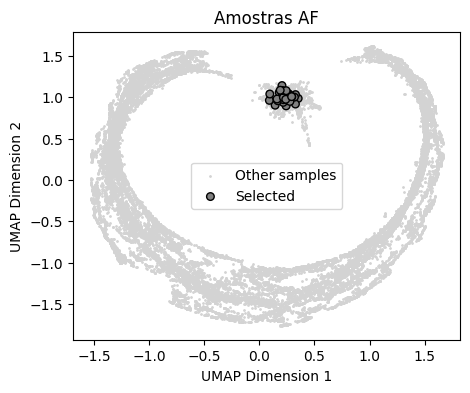

In [11]:
# GERAR CSV RESULTADOS

# GUARDAR EM CSVS

doenca = 'AF'

colunas_desejadas = ['exam_id', 'label', '1dAVb', 'RBBB', 'LBBB' , 'SB' ,'ST' , 'AF', 'normal_ecg', 'silhouette_score']
dados = merged_data[colunas_desejadas]
dados = dados.sort_values(by=['label', 'silhouette_score'], ascending=[True, False])

conditions = [
    (dados['label'] == 0) & (dados[doenca] == True), (dados['label'] == 0) & (dados[doenca] == False),
    (dados['label'] == 1) & (dados[doenca] == True), (dados['label'] == 1) & (dados[doenca] == False),
    (dados['label'] == 2) & (dados[doenca] == True), (dados['label'] == 2) & (dados[doenca] == False),
    (dados['label'] == -1) & (dados[doenca] == True), (dados['label'] == -1) & (dados[doenca] == False)
]
choices = [
    'D_clusterD', 'N_clusterD',
    'D_clusterN','N_clusterN',
    'D_clusterM','N_clusterM',
    'D_clusterO','N_clusterO',
]

dados['tipo'] = np.select(conditions, choices, default='Unknown')

dados.to_csv(f'gerais/{doenca}_geral.csv', index=False)

# GERAR AMOSTRAS

def select_25_evenly_spaced(df):
    total_rows = len(df)
    if total_rows <= 25:
        return df
    else:
        indices = np.linspace(0, total_rows-1, 45, dtype=int)
        return df.iloc[indices]
    
dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_25_evenly_spaced)

tipos_desejados = ['D_clusterD']
dados_selecionados = dados_selecionados[dados_selecionados['tipo'].isin(tipos_desejados)]

dados_selecionados.to_csv(f'amostras/{doenca}_amostras.csv', index=False)

#PLOTAR AMOSTRAS

def plot_samples(X, exam_ids, labels, title):
    colors = ['gray',    # 0: Other samples
              'yellow',  # 1: D_clusterN
              'orange',  # 2: N_clusterD
              'blue',    # 3: D_clusterM
              'red',     # 4: N_clusterM
              'purple',  # 5: D_clusterO
              'green']   # 6: N_clusterO
    exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
    sample_indices = [exam_id_to_index[exam_id] for exam_id in exam_ids]

    all_labels = np.zeros(X.shape[0])
    all_labels[sample_indices] = labels

    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=1, label='Other samples')
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], c=[colors[label] for label in labels], s=30, edgecolor='k', label='Selected')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title(title)
    plt.legend()
    plt.show()

selected_exam_ids = dados_selecionados['exam_id'].values

exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
selected_indices = [exam_id_to_index[exam_id] for exam_id in selected_exam_ids]

labels = [
    1 if tipo == 'D_clusterN' else 2 if tipo == 'N_clusterD' else
    3 if tipo == 'D_clusterM' else 4 if tipo == 'N_clusterM' else
    5 if tipo == 'D_clusterO' else 6 if tipo == 'N_clusterO' else 0
    for tipo in dados_selecionados['tipo'].values
]

plot_samples(X_reduced_scaled, selected_exam_ids, labels, f'Amostras {doenca}')